In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import os

from model.datasets import get_loaders
from model.ddpm import DiffusionTrainer, DiffusionSampler
from model.unet import Unet
from model.training import train, sample
from model.utils import SaveBestModel, load_model, plot_images
from model.metrics import fid_score

import gc
from tqdm.notebook import tqdm

In [34]:
torch.cuda.empty_cache()
gc.collect()

7087

In [6]:
CUDA = 0
batch_size = 32

train_loader, val_loader = get_loaders('cifar10', batch_size=batch_size)
device = torch.device(f"cuda:{CUDA}" if torch.cuda.is_available() else "cpu")
device

Files already downloaded and verified


In [8]:
config = {
    'lr': 2e-4,
    'start_epoch': 0,
    'n_epochs': 5,
    'warmup': 5000,
    'model_path': 'bin/cifar10.pth'
}

unet = Unet(T=1000, ch=128, ch_mult=[1, 2, 2, 2], attn=[1], num_res_blocks=2, dropout=0.1)
trainer = DiffusionTrainer(unet).to(device)

optimizer = optim.Adam(trainer.parameters(), lr=config['lr'])
#optimizer = optim.SGD(model.parameters(), lr=args.lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda epoch: min(epoch, config['warmup']) / config['warmup'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

model_saver = SaveBestModel()

writer = SummaryWriter()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.77 GiB total capacity; 177.72 MiB already allocated; 13.19 MiB free; 180.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
train(
    trainer,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    device,
    config['start_epoch'] + config['n_epochs'],
    config['start_epoch'],
    model_saver,
    config['model_path'],
    writer
)

Training epoch 1/5:   0%|          | 0/704 [00:03<?, ?it/s]


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

In [72]:
fake_data = sample(model, batch_size, (3, 32, 32), batch_size, device)
torch.save(fake_data, 'fake_data.pt')

Going to sample 1 batches
Sampling 1 batch...


100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]


In [79]:
real_data = next(iter(dataloader))[0]
real_data = denormalize(real_data).detach().cpu()

fake_data = torch.load('fake_data.pt')
fake_data = denormalize(fake_data).detach().cpu()

print(real_data.shape, real_data.dtype)
print(fake_data.shape, fake_data.dtype)

torch.Size([64, 3, 32, 32]) torch.float32
torch.Size([64, 3, 32, 32]) torch.float32


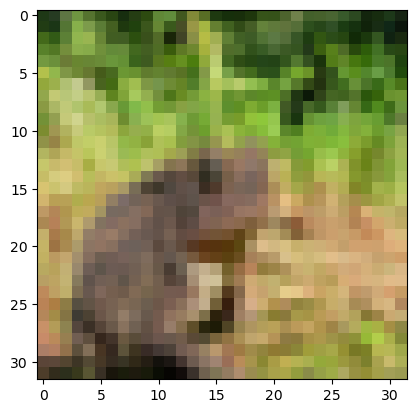

In [78]:
import matplotlib.pyplot as plt

plt.imshow(real_data[0,...].permute(1, 2, 0).cpu())

In [81]:
fid = fid_score(real_data, fake_data)
fid

7.923732280731201